In [1]:
import numpy as np
import math
import xarray as xr
from dask import array as da_array
import psutil
from os import getpid
import gc
from time import process_time as ostime
from time import sleep
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from threading import Thread
from threading import Event
from PFL_memory_supplements import *
from IPython.display import Image
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


## Python for Lunch (PFL) - Performance Sessions - High-Speed, Dynamic File Access

### Motivation

Python is a great introductory programming language with many safeguards and comfort functions that easy in learning.
Most errors occuring during initial coding are easily counter-acted with hands-on guidance from internet sources.
Barriers that remain and in programming and that are most common for novice programmers loosing interest are 2 points related to performance:

- *Memory errors*: An infamous "productivity stopper" is an error such as ```MemoryError: out of memory```, which is often reached when using scientific data (e.g. hydrodynamic data) on laptops or workstations
- *Slow computations*: if a simple computation takes hours or days, most users are starting being annoyed by software and programming

Furthermore, both issues are (often) not easily resolvable by simple googling. 

In this section, we have a sneak-peak on the **data** aspect of performance. Most importantly, we want to answer the following questions:

**What can we do in terms of basic programming guidelines to avoid memory over-usage ?** 

**Are there packages that allow speedy and comfortable processing of large chunks of data ?**


### Preparations

In order to track down memory issues and evaluate the quality of our optimizations, we first need some means of tracking the memory consumption of our program.
The `psutil` package in this case provides us with the relevant information. As an example, in order to see how much memory (in bytes) our Jupyter script consumes, we use the following statement:

In [2]:
import psutil
from os import getpid

mem_consumed = psutil.Process(getpid()).memory_info().rss
print("Memory consumed by this Jupyter process: {} B (~{} MB)".format(mem_consumed, mem_consumed / (1024 * 1024)))

Memory consumed by this Jupyter process: 127983616 B (~122.0546875 MB)


Now, because we want to to measure this memory consumption in the background without disrupting our hydrodynamic calculations, we create a simple helper class that measures this values continuously in a given periodic `interval`. That is what we have the `BackgroundMeasureMemory` class for.

In [3]:
class BackgroundMeasureMemory(object):
    def __init__(self, interval):
        self.interval = interval
        self.start = ostime()
        self._mem_start = psutil.Process(getpid()).memory_info().rss
        self._mem_measurement = []
        if self._mem_start > 0:
            self._mem_measurement.append(0)
        self.event = Event()
        self.thread = Thread(target=self._target)
        self.thread.start()

    def __del__(self):
        del self._mem_measurement

    def _target(self):
        if self._mem_start <= 0:
            self._mem_start = psutil.Process(getpid()).memory_info().rss
            self._mem_measurement.append(0)
        while not self.event.is_set():
            self._mem_measurement.append( (psutil.Process(getpid()).memory_info().rss-self._mem_start)/1024.0 )
            sleep(self.interval)

    def stop(self):
        self.event.set()
        self.thread.join()

    def get_measurement(self):
        return self._mem_measurement

Note that this class takes an initial measurement and later only stores the memory differences. This is so we can better track what's the specific memory consumption of our hydrodynamic code alone.

In the next step, we generate ourselves a small example dataset from the common *stommel* field equation. 

In [4]:
timed_mem_comume_np = BackgroundMeasureMemory(0.01)
sleep(0.1)

mem_consumed_s = psutil.Process(getpid()).memory_info().rss
time_s_genStommel_np = ostime()
U, V = create_stommel_array()
time_e_genStommel_np = ostime()
mem_consumed_e = psutil.Process(getpid()).memory_info().rss
print("Time to generate stommel dataset in NumPy: {:10.6f} sec.".format(time_e_genStommel_np-time_s_genStommel_np))
print("Memory consumed by the basic stommel field: {} KB".format((mem_consumed_e-mem_consumed_s)/1024))

Time to generate stommel dataset in NumPy:   0.375461 sec.
Memory consumed by the basic stommel field: 0.0 KB


In the next step, we compute the convolution of the 'U' flow component of stommel with a gaussian 5x5 kernel. This will illustrate a common kernel-based processing function
of hydrodynamic data.

In [5]:
def get_lib(a):
    return np if not isinstance(a, da_array.core.Array) else da_array

def convolve(a, kernel, with_gc=False):
    out_buffer = np.zeros(a.shape, dtype=a.dtype)
    assert a.dtype==kernel.dtype
    ik_buffer = np.zeros(kernel.shape, dtype=a.dtype)
    out_mat = np.zeros(kernel.shape, dtype=a.dtype, order='C')
    k_xi_diff = int((kernel.shape[0]-1)/2)
    k_yi_diff = int((kernel.shape[1]-1)/2)
    N = a.shape[0]*a.shape[1]
    print("N = {}".format(N))
    last_out = -1
    # use_da = isinstance(a, da_array.core.Array)
    for i in range(a.shape[0]*a.shape[1]):
        ik_buffer.fill(0)
        xi = int(i/a.shape[0])
        yi = int(i%a.shape[0])
        xi_a_min = max((xi-k_xi_diff), 0)
        yi_a_min = max((yi-k_yi_diff), 0) # %a.shape[0]
        xi_a_max = min((xi+k_xi_diff), a.shape[0]-1)
        yi_a_max = min((yi+k_yi_diff), a.shape[1]-1)
        k_xi_a_min = (xi_a_min - xi) + k_xi_diff
        k_yi_a_min = (yi_a_min - yi) + k_yi_diff
        k_xi_a_max = (xi_a_max - xi) + k_xi_diff
        k_yi_a_max = (yi_a_max - yi) + k_yi_diff
        ik_buffer[k_xi_a_min:(k_xi_a_max+1), k_yi_a_min:(k_yi_a_max+1)] = a[xi_a_min:(xi_a_max+1), yi_a_min:(yi_a_max+1)]

        perc_int = int((float(i)/N)*100.0)
        if (perc_int % 10) == 0 and perc_int != last_out:
            print("Convolution done by {} percent ...".format(perc_int))
            last_out = perc_int
            if with_gc:
                gc.collect()
        np.dot(ik_buffer, kernel, out_mat)
        out_buffer[xi, yi] = np.nanmean(out_mat.flatten())
    return out_buffer


x, y = np.meshgrid(np.linspace(-1,1,5), np.linspace(-1,1,5))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) ).astype(dtype=np.float32)

When the processing is now being executed, we time the execution and simultaneously log the memory consumption. 
This does not only provide us with a memory requirement estimate, but we can later also compare those measurements with
alternative data handling techniques to see what we gain or loose in terms of memory consumption and speed.
            

N = 10000
Convolution done by 0 percent ...
Convolution done by 10 percent ...
Convolution done by 20 percent ...
Convolution done by 30 percent ...
Convolution done by 40 percent ...
Convolution done by 50 percent ...
Convolution done by 60 percent ...
Convolution done by 70 percent ...
Convolution done by 80 percent ...
Convolution done by 90 percent ...
Time to convolve stommel dataset with 5x5 gaussian kernel in NumPy:   1.596555 sec.
Time to compute the flow magnitude of stommel in NumPy:   0.000371 sec.


No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


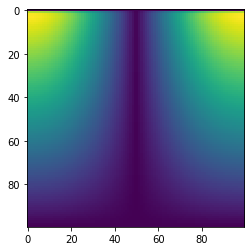

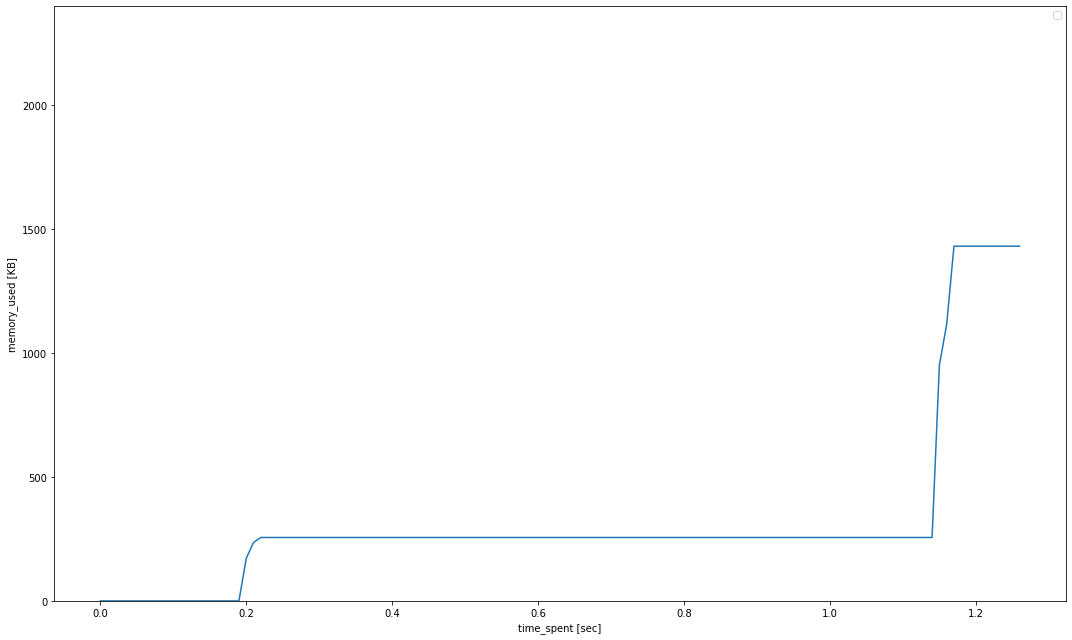

In [6]:
time_s_conv_np = ostime()
d_res_np = convolve(U, g)
time_e_conv_np = ostime()
print("Time to convolve stommel dataset with 5x5 gaussian kernel in NumPy: {:10.6f} sec.".format(time_e_conv_np-time_s_conv_np))
imshow(np.asarray(np.array(d_res_np)))
del d_res_np
time_s_gradmag_np = ostime()
d_res_np = np.sqrt(np.square(U) + np.square(U))
time_e_gradmag_np = ostime()
print("Time to compute the flow magnitude of stommel in NumPy: {:10.6f} sec.".format(time_e_gradmag_np-time_s_gradmag_np))
imshow(np.asarray(np.array(d_res_np)))
del d_res_np
sleep(0.1)
timed_mem_comume_np.stop()

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
plot_mem = timed_mem_comume_np.get_measurement()
plot_t = np.arange(0, len(plot_mem), dtype=np.float32) * 0.01
ax.plot(plot_t, plot_mem)
ax.set_ylim([0, 2400])
ax.legend()
ax.set_xlabel('time_spent [sec]')
ax.set_ylabel('memory_used [KB]')
fig.tight_layout()
fig.show()
del timed_mem_comume_np

We see in the numbers and plots that there is an initial increase in memory consumption when generating the stommel field.
Another increase is marked by allocating the buffers variables `out_buffer`, `ik_buffer` and `out_mat` in the `convolve(a, kernel)` function above,
and the allocation of the return varianle `d_res_np`. Once those dense matrices (or: dense arrays) are allocated, the memory consumption stays constant.

We want to note here that temporary arrays are explicitly destroyed via `del <array>` to clean up the memory and not leave large memory segments in a *ghost* state. Furthermore,
actively enforcing the **garbage collection** of *ghost* memory segments can relieve the stress on available memory requirements and reduce the *used memory (in bytes)*. it
can be actvated with calling the *convolve*-function as `convolve(a, kernel, True)`.

### Chunking data with Dask

Based on the measured observation, we can deduce that, if it is required to process all elements of a hydrodynamic field, we need access to all data elements,
which leads to a constant, high memory requirement. In ocean sciences, while the hydrodynamic data may be stored on a global scale, we often care about specific
regions in our study. Thus, wouldn't it be nice to _not_ require the global ocean data to be present in memory when just focusing on a sub-region ?

This situation is similar to many other physical studies and disciplines. Because of that need for clever data access, `Dask` was created. 
`Dask` is a python packages that allows 'undercover' local data access while pointing to global, super-large datasets.

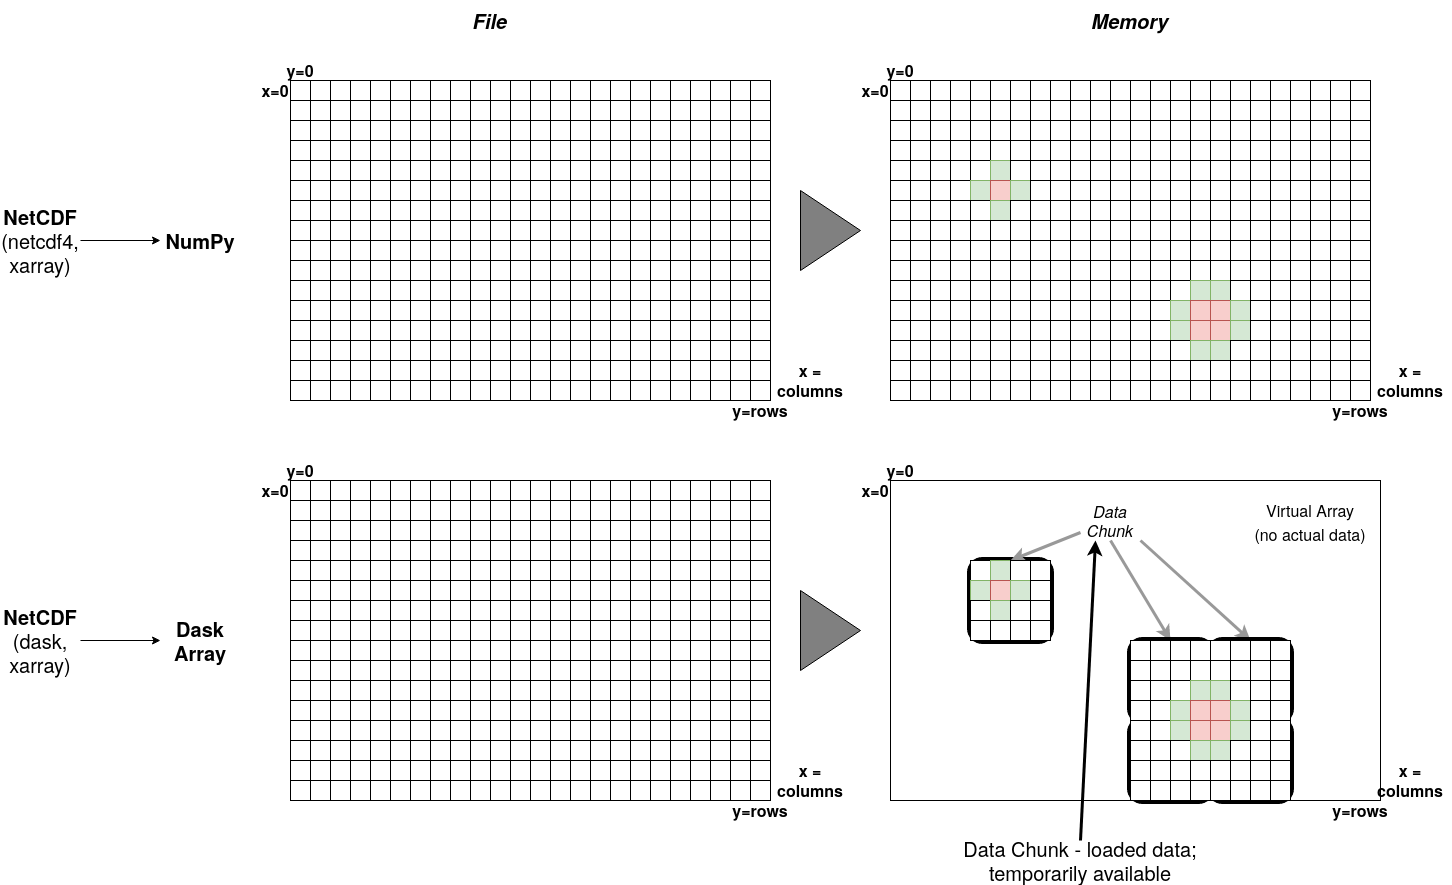

In [7]:
#![Chunking Explanation](img/Dask_Chunking.png)
Image("img/Dask_Chunking.png")

Chunking works by parsing the *metadata* of a data structure (in terms of its extents and datatype) and create
a *virtual array* based on those metadata. The virtual array is only a container - it does not hold any actual data.
It is a *descriptor* of the data layout, which is sufficient for addressing and *pre-calculating* functions. Data are not loaded.
The data are only loaded when (i) explicitly requested (e.g. by directly reading a specific value, or initiate a `array.compute(...)`)
or (iI) when a specific calculation requires reading the actual data. Those data are automatically discarded after use.

Note that, while data offers *interoperability* with NumPy, those are not the same thing. NumPy data are not automatically discarded
after use. Hence, mixing **Dask** and **NumPy** can lead to memory leakage and memory issues. 

In order to observe the *dynamic data-loading* feature in action, we pick up our above example. First, we create chunked `dask` arrays from the underlying `numpy` fields. 

In [8]:
timed_mem_consume_da = BackgroundMeasureMemory(0.01)
sleep(0.1)
time_s_convertStommel_da = ostime()
stommel_u_da_base = da_array.from_array(U, chunks=(64, 64))
stommel_v_da_base = da_array.from_array(V, chunks=(64, 64))
time_e_convertStommel_da = ostime()
print("Time to generate stommel dataset in Dask: {:10.6f} sec.".format(time_e_convertStommel_da-time_s_convertStommel_da))

Time to generate stommel dataset in Dask:   0.008518 sec.


Next, we execute the field-gaussian convolution and the flow magnitude computation again and measure the memory behaviour.

N = 10000
Convolution done by 0 percent ...
Convolution done by 10 percent ...
Convolution done by 20 percent ...
Convolution done by 30 percent ...
Convolution done by 40 percent ...
Convolution done by 50 percent ...
Convolution done by 60 percent ...
Convolution done by 70 percent ...
Convolution done by 80 percent ...
Convolution done by 90 percent ...
Time to convolve stommel dataset with 5x5 gaussian kernel in Dask:  30.728187 sec.
Time to compute the flow magnitude of stommel in Dask:   0.002578 sec.


No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


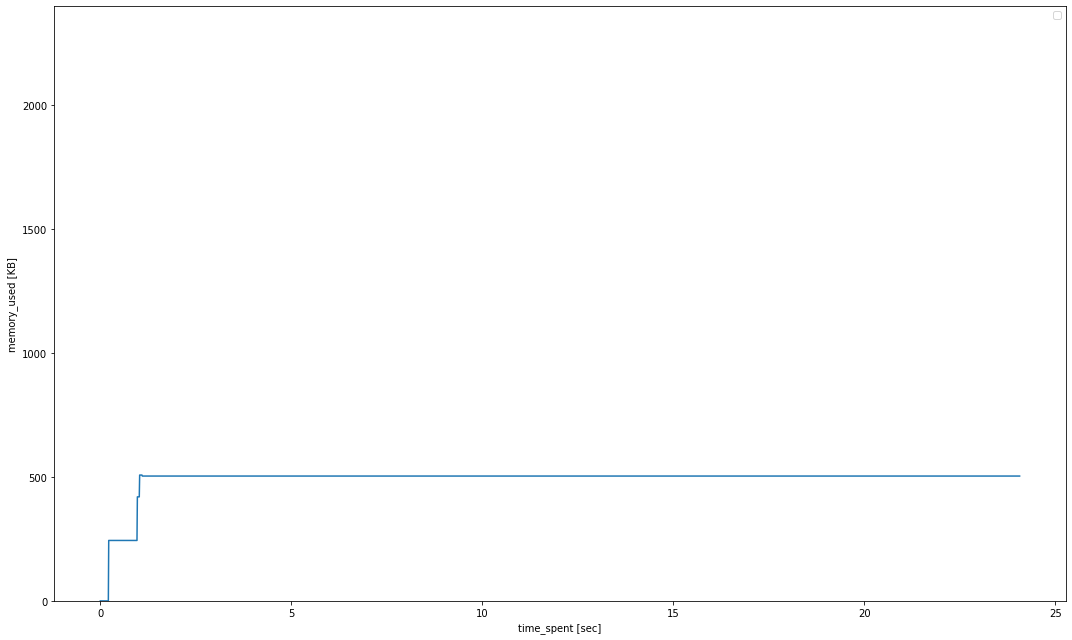

In [9]:
time_s_conv_da = ostime()
d_res_da = convolve(stommel_u_da_base, g)
time_e_conv_da = ostime()
print("Time to convolve stommel dataset with 5x5 gaussian kernel in Dask: {:10.6f} sec.".format(time_e_conv_da-time_s_conv_da))
del d_res_da
time_s_gradmag_da = ostime()
# d_res_da = da_array.square(stommel_u_da_base*stommel_v_da_base)/(da_array.fabs(stommel_u_da_base) * np.fabs(stommel_v_da_base))
d_res_da = da_array.sqrt(da_array.square(stommel_u_da_base) + da_array.square(stommel_v_da_base))
time_e_gradmag_da = ostime()
print("Time to compute the flow magnitude of stommel in Dask: {:10.6f} sec.".format(time_e_gradmag_da-time_s_gradmag_da))
del d_res_da
del stommel_u_da_base
del stommel_v_da_base
sleep(0.1)
timed_mem_consume_da.stop()

fig_da, ax_da = plt.subplots(1, 1, figsize=(15, 9))
plot_mem = timed_mem_consume_da.get_measurement()
plot_t = np.arange(0, len(plot_mem), dtype=np.float32) * 0.01
ax_da.plot(plot_t, plot_mem)
ax_da.set_ylim([0, 2400])
ax_da.legend()
ax_da.set_xlabel('time_spent [sec]')
ax_da.set_ylabel('memory_used [KB]')
fig_da.tight_layout()
fig_da.show()
del timed_mem_consume_da


What we can see in this measurement is that there is no steep ram in the graph, but rather more a (quick) gradual, step-wise increase in the memory cosumption.
That is because, during the convolution, `Dask` is not loading all the data at once, but it requests the data of each field cell in chunks of `64 x 64 x 4B = 2^15B = 16KB` increments.
But why does it consume more memory than the numpy-only version ? Shouldn't it be more efficient ?

(1) The numpy base data are still in memory. `Dask` in this case provides a hardcopy of the individual chunks. Hence the memory consumption is naturally higher, because the base data need to be present.

(2) `Dask` only loads the data that need to be there for the calculation. If our calculation span the entire data domain (i.e. all entries in `U` and `V`), we do not gain anything from dynamic loading.

 On point (2): we can show that data are dynamically loaded and unloaded by forcing Python's `garbage collector` to collect irrelevant chunks during the convolution, as follows:
 

N = 10000
Convolution done by 0 percent ...
Convolution done by 10 percent ...
Convolution done by 20 percent ...
Convolution done by 30 percent ...
Convolution done by 40 percent ...
Convolution done by 50 percent ...
Convolution done by 60 percent ...
Convolution done by 70 percent ...
Convolution done by 80 percent ...
Convolution done by 90 percent ...
Time to convolve stommel dataset with 5x5 gaussian kernel in Dask:  31.028156 sec.


No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


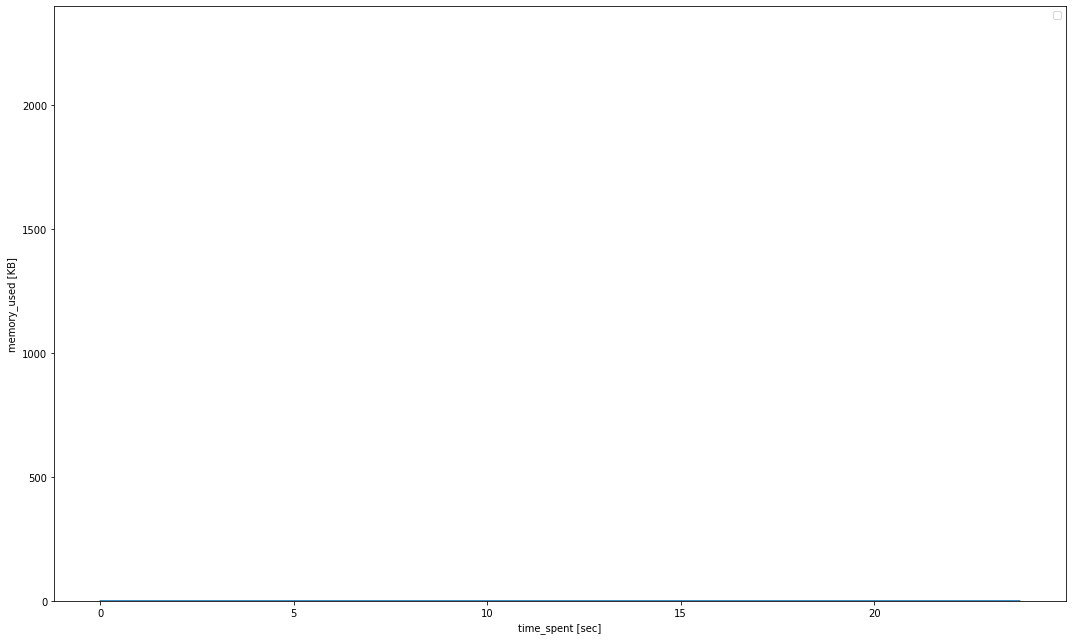

In [10]:
timed_mem_consume_da = BackgroundMeasureMemory(0.01)
sleep(0.1)
time_s_convertStommel_da = ostime()
stommel_u_da_base = da_array.from_array(U, chunks=(64, 64))
stommel_v_da_base = da_array.from_array(V, chunks=(64, 64))
time_s_conv_da = ostime()
d_res_da = convolve(stommel_u_da_base, g, with_gc=True)
time_e_conv_da = ostime()
print("Time to convolve stommel dataset with 5x5 gaussian kernel in Dask: {:10.6f} sec.".format(time_e_conv_da-time_s_conv_da))
del d_res_da
del stommel_u_da_base
del stommel_v_da_base
del U
del V
sleep(0.1)
timed_mem_consume_da.stop()

fig_da, ax_da = plt.subplots(1, 1, figsize=(15, 9))
plot_mem = timed_mem_consume_da.get_measurement()
plot_t = np.arange(0, len(plot_mem), dtype=np.float32) * 0.01
ax_da.plot(plot_t, plot_mem)
ax_da.set_ylim([0, 2400])
ax_da.legend()
ax_da.set_xlabel('time_spent [sec]')
ax_da.set_ylabel('memory_used [KB]')
fig_da.tight_layout()
fig_da.show()
del timed_mem_consume_da
 

As we see, when controlling the garbage collection, we get a different picture: the memory consumtion is constantly low (at the expense of a little longer runtime), as data chunks are constantly loaded and unloaded from memory.
What you can also see here is that this dynamic loading bears a cost: as `Dask` constantly needs to search (in the background) for the required data chunks relevant for the given field index, the computation takes longer to finish.

## Loading data from file - the _real_ strength of 'Dask' and dynamic loading

Chunking (field) data that is already in the memory has little use or relevance for all but niche corner cases. 
The point where data chunking becomes _actually_ important is in accessing physical data from files.

We measure the impact of static vs. dynamic data loading by accessing the same hydrodynamic data as before - the stommel dataset - from file. 
In order to show the drastic impact, the file version does not consist of `200 x 200` grid points, but of `10,000 x 10,000`.
This direct comparison is easiest facilitated within the `xarray` package (see PFL session 4 'xarray' by Leo van Kampenhout).
In the first instance, we access the data statically by opening the file for the `U` flow component and measure the memory consumption.
 

In [11]:
proc = psutil.Process(getpid())
gc.collect()
time_s_load_stommel = ostime()
mem_used_before = proc.memory_info().rss
stommel_data = xr.open_dataset("./stommel_largeU.nc", decode_cf=True, engine='netcdf4')
stommel_data['decoded'] = True
xdim = stommel_data.dims['x']
ydim = stommel_data.dims['y']
print("xdim: {}; ydim: {}".format(xdim, ydim))
stommel_u = stommel_data["vozocrtx"]
if isinstance(stommel_u, xr.DataArray):
    stommel_u = stommel_u.data
time_e_load_stommel = ostime()
print("Matrix/DenseArray type: {}".format(type(stommel_u)))
cell_size = int(math.ceil(np.finfo(stommel_u.dtype).bits)/8)
mem_used_after = proc.memory_info().rss
stommel_size = (mem_used_after-mem_used_before)/1024
print("Stommel dataset - memory size: {} KB".format(stommel_size))
print("Stommel dataset - size of single cell: {} B".format(cell_size))
print("Time to load stommel from Harddisk -> Memory: {:10.5f} s".format(time_e_load_stommel-time_s_load_stommel))

xdim: 10000; ydim: 10000
Matrix/DenseArray type: <class 'numpy.ndarray'>
Stommel dataset - memory size: 400268.0 KB
Stommel dataset - size of single cell: 4 B
Time to load stommel from Harddisk -> Memory:    1.17952 s


Now, we generate an arbitrary field coordinate and access its value in the static data, measuring memory consumption again.

In [12]:
# coords_1 = np.random.randint((0, 0), (xdim, ydim), 2, dtype=np.int32)
coords_1 = np.array([24, 32], dtype=np.int32)
time_idx = 0
depth_idx = 0
mem_used_before_cellaccess = proc.memory_info().rss
print("Accessing element ({}, {}, {}, {})".format(time_idx, depth_idx, coords_1[1], coords_1[0]))
time_s_load_cell = ostime()
d_element = stommel_u[time_idx, depth_idx, coords_1[1], coords_1[0]]
time_e_load_cell = ostime()
print("Element value: {}".format(d_element))
mem_used_after_cellaccess = proc.memory_info().rss
print("Memory consumption:                              {} KB".format((mem_used_after_cellaccess-mem_used_before)/1024))
print("Extra memory consumption from loading cell:      {} B".format(mem_used_after_cellaccess-mem_used_before_cellaccess))
print("Time to load data cell from Memory -> Cache/CPU: {:10.3E} s".format(time_e_load_cell-time_s_load_cell))
del d_element

Accessing element (0, 0, 32, 24)
Element value: -0.18727174401283264
Memory consumption:                              400268.0 KB
Extra memory consumption from loading cell:      0 B
Time to load data cell from Memory -> Cache/CPU:  3.687E-04 s


And now, instead of excessing just 1 field item, we access a whole region, load the field region, and scale the `U` component velocities in that area.

In [13]:
# coords_2 = np.random.randint((0, 0), (xdim, ydim), 2, dtype=np.int32)
# coords = np.concatenate((coords_1.reshape(coords_1.shape[0], 1), coords_2.reshape(coords_2.shape[0], 1)), axis=1) 
# slice_coords = [[np.min(coords, 0)[0], np.max(coords, 0)[0]],
#                 [np.min(coords, 0)[1], np.max(coords, 0)[1]]]
slice_coords = [[1280, 5472],
                [1920, 3968]]
mem_used_before_fieldaccess = proc.memory_info().rss
print("Accessing subfield ({}, {}, {}:{}, {}:{})".format(time_idx, depth_idx, slice_coords[0][0],slice_coords[0][1], slice_coords[1][0],slice_coords[1][1]))
time_s_load_subfield = ostime()
d_slice_1 = stommel_u[time_idx, depth_idx, slice_coords[0][0]:slice_coords[0][1], slice_coords[1][0]:slice_coords[1][1]]
time_e_load_subfield = ostime()
# print("Sub-field 1: {}".format(d_slice_1))
time_s_mul_subfield = ostime()
d_res = d_slice_1 * 5.0
time_e_mul_subfield = ostime()
# print("field 1 * 5: {}".format(d_res))
mem_used_after_fieldaccess = proc.memory_info().rss
stommel_subsize = (mem_used_after_fieldaccess-mem_used_before)/1024
extra_stommel_subsize = mem_used_after_fieldaccess-mem_used_before_fieldaccess
print("Memory consumption:                     {} KB".format(stommel_subsize))
print("Expected additional memory consumption: {} KB".format((slice_coords[0][1]-slice_coords[0][0])*(slice_coords[1][1]-slice_coords[1][0])*cell_size/1024))
print("Actual additional memory consumption:   {} KB".format(extra_stommel_subsize/1024))
print("Time to load subfield (load data from Memory -> Cache/CPU): {:10.3E} s".format(time_e_load_subfield-time_s_load_subfield))
print("Time to multiply subfield (no actual data load):            {:10.3E} s".format(time_e_mul_subfield-time_s_mul_subfield))
del d_slice_1
del d_res
del stommel_u
stommel_data.close()
del stommel_data

Accessing subfield (0, 0, 1280:5472, 1920:3968)
Memory consumption:                     433640.0 KB
Expected additional memory consumption: 33536.0 KB
Actual additional memory consumption:   33372.0 KB
Time to load subfield (load data from Memory -> Cache/CPU):  5.030E-04 s
Time to multiply subfield (no actual data load):             9.077E-02 s


What we observe is that, with the first data access, we load all data into memory. 
Reading one field item does not affect the memory consumption - at least not by a measureable quantity (i.e. storing the field item in `d_element` does consume `1x 4 Byte`, bon on the `KB` scale, it is not captured).
Reading (1 subfield) and multiplying (1 subfield) the chosen region consumes exactly `<region_size x> x <region_size_y> x 4 Byte` extra memory.
Those results are as expected and logical.

What happens now if we access the file data dynamically, via `Dask` ?  

In [14]:
import os, requests

if not os.path.exists('stommel_largeU.nc'):
    data_url = "https://surfdrive.surf.nl/files/index.php/s/Sng6Kmy1GExbMUq/download"
    # data_url = "https://surfdrive.surf.nl/files/index.php/s/T7QyLbGjaGMdnVD/download"
    requests.get(data_url)

chunksize = (128, 128)
chunksize_bytes = chunksize[0]*chunksize[1]*cell_size
proc = psutil.Process(getpid())
gc.collect()
time_s_load_stommel_da = ostime()
mem_used_before_da = proc.memory_info().rss
stommel_data_da = xr.open_dataset("./stommel_largeU.nc", decode_cf=True, engine='netcdf4', chunks={'x': chunksize[0], 'y': chunksize[1]})
stommel_data_da['decoded'] = True
stommel_u_da = stommel_data_da["vozocrtx"]
if isinstance(stommel_u_da, xr.DataArray):
    stommel_u_da = stommel_u_da.data
time_e_load_stommel_da = ostime()
print("Matrix/DenseArray type (with Dask): {}".format(type(stommel_u_da)))
mem_used_after_da = proc.memory_info().rss
stommel_size_da = (mem_used_after_da-mem_used_before_da)/1024
print("Stommel dataset - memory size (with Dask): {} KB".format(stommel_size_da))
print("Stommel dataset - chunk size:              {} B ({:.2f} KB)".format(chunksize_bytes, chunksize_bytes/1024))
print("Time to load stommel from Harddisk -> Memory (with Dask): {:10.5f} s".format(time_e_load_stommel_da-time_s_load_stommel_da))

Matrix/DenseArray type (with Dask): <class 'dask.array.core.Array'>
Stommel dataset - memory size (with Dask): 4404.0 KB
Stommel dataset - chunk size:              65536 B (64.00 KB)
Time to load stommel from Harddisk -> Memory (with Dask):    0.07242 s


What we observe with dynamic loading - by defining a chunk size and locking the file - is that only very little memory is consumed by opening the file, at least much less than `10,000 x 10,000 x 4 / 1024 = 390,625 KB`.
This is because `Dask` only allocates a 'virtual data array'. A 'virtual data array' is a data structure that only holds the array metadata (e.g. data type, array boundary coordinates, dimensionality ...) and an empty template grid. It also holds the information about how the file is being split in `chunks`.
The data stays virtual as long as we only access meta data.

In [15]:
mem_used_before_cellaccess_da = proc.memory_info().rss
print("Accessing element ({}, {}, {}, {})".format(time_idx, depth_idx, coords_1[1], coords_1[0]))
time_s_load_cell_da = ostime()
d_element_da = stommel_u_da[time_idx, depth_idx, coords_1[1], coords_1[0]]
time_e_load_cell_da = ostime()
print("Element value (with Dask): {}".format(d_element_da.compute()))
mem_used_after_cellaccess_da = proc.memory_info().rss
mem_used_cellaccess_da = mem_used_after_cellaccess_da-mem_used_before_cellaccess_da
print("Memory consumption (with Dask):                         {} KB".format((mem_used_after_cellaccess_da-mem_used_before_da)/1024))
print("Estim. extra memory consumption from loading cell:      {} B ({:.2f} KB)".format(chunksize_bytes, chunksize_bytes/1024))
print("Extra memory consumption from loading cell (with Dask): {} B ({:.2f} KB)".format(mem_used_cellaccess_da, mem_used_cellaccess_da/1024))
print("Time to load data cell from Memory -> Cache/CPU (with Dask): {:10.3E} s".format(time_e_load_cell_da-time_s_load_cell_da))
del d_element_da

Accessing element (0, 0, 32, 24)
Element value (with Dask): -0.18727174401283264
Memory consumption (with Dask):                         4616.0 KB
Estim. extra memory consumption from loading cell:      65536 B (64.00 KB)
Extra memory consumption from loading cell (with Dask): 217088 B (212.00 KB)
Time to load data cell from Memory -> Cache/CPU (with Dask):  2.865E-03 s


Data is actually allocated when we access a specific field item. At that point though, `Dask` not only creates a 4-byte variable for the data, but also *physically* loads the whole chunk into memory where the requested coordinate is located. Note though that it only loads one chunk (here: `128 x 128 x 4 Byte = 64 KB`).

In [16]:
mem_used_before_fieldaccess_da = proc.memory_info().rss
print("Accessing subfield ({}, {}, {}:{}, {}:{})".format(time_idx, depth_idx, slice_coords[0][0],slice_coords[0][1], slice_coords[1][0],slice_coords[1][1]))
time_s_load_subfield_da = ostime()
d_slice_1_da = stommel_u_da[time_idx, depth_idx, slice_coords[0][0]:slice_coords[0][1], slice_coords[1][0]:slice_coords[1][1]]
time_e_load_subfield_da = ostime()
# print("Sub-field 1: {}".format(d_slice_1_da.compute()))
time_s_mul_subfield_da = ostime()
d_res = d_slice_1_da * 5.0
time_e_mul_subfield_da = ostime()
# print("field 1 * 5: {}".format(d_res.compute()))
mem_used_after_fieldaccess_da = proc.memory_info().rss
stommel_subsize_da = (mem_used_after_fieldaccess_da-mem_used_before_da)/1024
extra_stommel_subsize_da = mem_used_after_fieldaccess_da-mem_used_before_fieldaccess_da
print("Memory consumption (with Dask):                      {:.2f} KB".format(stommel_subsize_da))
print("Estimated additional memory consumption (with Dask): {:.2f} KB".format((math.ceil((slice_coords[0][1]-slice_coords[0][0])/chunksize[0])*math.ceil((slice_coords[1][1]-slice_coords[1][0])/chunksize[1])*cell_size)/1024))
print("Actual additional memory consumption (with Dask):    {:.2f} KB".format(extra_stommel_subsize_da/1024))
print("Time to load subfield (no actual data load):                    {:10.3E} s".format(time_e_load_subfield_da-time_s_load_subfield_da))
print("Time to multiply subfield (load data from Memory -> Cache/CPU): {:10.3E} s".format(time_e_mul_subfield_da-time_s_mul_subfield_da))
del d_slice_1_da
del d_res
del stommel_u_da
stommel_data_da.close()
del stommel_data_da
load_file_nc = time_e_load_stommel-time_s_load_stommel
load_file_da = time_e_load_stommel_da-time_s_load_stommel_da
print("==== COMPARISON - Load file:                         {:10.3f} (NumPy) vs {:10.3f} (Dask)".format(load_file_nc, load_file_da))
# load_ind_item = time_e_load_cell-time_s_load_cell
# load_ind_item_da = time_e_load_stommel_da-time_s_load_stommel_da
# print("==== COMPARISON - Access individual data:        {:10.3E} (NumPy) vs {:10.3E} (Dask)".format())
load_access_subfield = time_e_load_subfield-time_s_load_subfield
load_access_subfield+= time_e_mul_subfield-time_s_mul_subfield
load_access_subfield_da = time_e_load_subfield_da-time_s_load_subfield_da
load_access_subfield_da+= time_e_mul_subfield_da-time_s_mul_subfield_da
print("==== COMPARISON - Access & Multiply field data:      {:10.3E} (NumPy) vs {:10.3E} (Dask)".format(load_access_subfield, load_access_subfield_da))
print("==== COMPARISON - Load & process data (cumulative):  {:10.3f} (NumPy) vs {:10.3f} (Dask)".format(load_file_nc+load_access_subfield, load_file_da+load_access_subfield_da))

Accessing subfield (0, 0, 1280:5472, 1920:3968)
Memory consumption (with Dask):                      4792.00 KB
Estimated additional memory consumption (with Dask): 2.06 KB
Actual additional memory consumption (with Dask):    164.00 KB
Time to load subfield (no actual data load):                     2.166E-03 s
Time to multiply subfield (load data from Memory -> Cache/CPU):  1.513E-02 s
==== COMPARISON - Load file:                              1.180 (NumPy) vs      0.072 (Dask)
==== COMPARISON - Access & Multiply field data:       9.127E-02 (NumPy) vs  1.730E-02 (Dask)
==== COMPARISON - Load & process data (cumulative):       1.271 (NumPy) vs      0.090 (Dask)


The same thing counts for accessing a sub-region (like: a study area) in the stored file: `Dask` only loads the the chunks that are covered by the requested area.

In turn, this means that - if combined with the `garbage collection` trick above - it would be possible to load data stored in a 1 Terabyte (TB) hydrodynamic field file and process it on your laptop or Mac, which has between 8 and 128 Gigabyte (GB).

So, no excuses anymore such as 'the data is too big to work with them on my computer' ? Hopefully so :-) 